# Analyzing umbrella sampling simulations with PyEMMA

### Example: the 1D asymmetric double well potential

Often in umbrella sampling, the bias is computed via a harmonic potential based on the deviation of a frame from a reference structure. In the usual one-dimensional case, this reads

$$b^{(i)}(\mathbf{x}) = \frac{k^{(i)}}{2} \left\Vert \mathbf{x} - \mathbf{x}^{(i)} \right\Vert^2.$$

In the more general case, though, one can use a non-symmetric force matrix:

$$b^{(i)}(\mathbf{x}) = \frac{1}{2} \left\langle \mathbf{x} - \mathbf{x}^{(i)} \middle\vert \mathbf{k}^{(i)} \middle\vert \mathbf{x} - \mathbf{x}^{(i)} \right\rangle.$$

In [1]:
# Imports and matplotlib customization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10

# Load precomputed simulation data
data = np.load('data/adw_us.npz', encoding='latin1')
us_trajs = [np.asarray(l, dtype=np.float64).reshape((-1, 1)) for l in data['arr_0'].tolist()]
us_centers = data['arr_1'].tolist()
us_force_constants = data['arr_2'].tolist()
md_trajs = [np.asarray(l, dtype=np.float64).reshape((-1, 1)) for l in data['arr_3'].tolist()]
centers = data['arr_4']
reference = data['arr_5']

### Looking at the data

We have a total of 12 umbrella sampling trajectories: each with a force constant of $5$ kT/a.u.$^2$, and three independent runs for each of the four umbrella centers $\mathbf{x}^{(i)}\in\{-1.29, -0.5, -0.1, 0.14\}$ a.u. (trajectory lengths varies for the different umbrella centers). The left plot shows the time evolution for all 12 runs (same color for same umbrella center) with dashed lines indicating the corresponding umbrella center.

On the right, we see the time evolution of 10 independent runs without bias.

We can observe two issues: 1) the umbrella sampling trajectories are well sampled and have much overlap in the range $-1.5 \leq x \leq 0$. 2) the unbiased trajectories sample only the ranges $-1.5 \leq x \leq -1.0$ and $0.8 \leq x \leq 1.5$ well, and we have very few crossings between these ranges.

force constants: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
umbrella centers: [-1.29, -1.29, -1.29, -0.5, -0.5, -0.5, -0.1, -0.1, -0.1, 0.14, 0.14, 0.14]


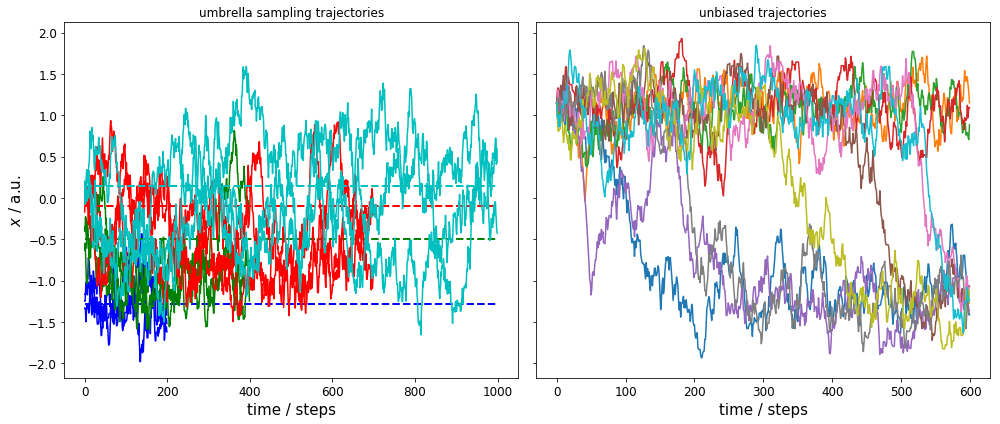

In [2]:
# Print the bias parameters
print("force constants: " + str(us_force_constants))
print("umbrella centers: " + str(us_centers))

# Plot the biased and unbiased trajectories
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for i, c in enumerate(['b', 'g', 'r', 'c']):
    for j in range(3):
        axes[0].plot(us_trajs[i * 3 + j], color=c)
    axes[0].plot([0, 1000], [us_centers[i * 3], us_centers[i * 3]], '--', linewidth=2, color=c)
for traj in md_trajs:
    axes[1].plot(traj)
axes[0].set_ylabel(r"$x$ / a.u.")
axes[0].set_title(r"umbrella sampling trajectories")
axes[1].set_title(r"unbiased trajectories")
for ax in axes.flat:
    ax.set_xlabel(r"time / steps")
fig.tight_layout()

### Discretization

We start by discretizing the loaded time series using predefined cluster centers.

In [3]:
us_dtrajs = pyemma.coordinates.assign_to_centers(data=us_trajs, centers=centers) # biased discrete trajectories
md_dtrajs = pyemma.coordinates.assign_to_centers(data=md_trajs, centers=centers) # unbiased discrete trajectories

HBox(children=(HBox(children=(Label(value='getting output of AssignCenters'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=12), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='getting output of AssignCenters'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

### Implied timescales

To get a first guess which lag time to use, we make an implied timescale plot: one with only the unbiased data and the standard MSM approach and one with all data and TRAM.

For the MSM, we create an implied timescales (ITS) object which can be passed to a suitable plotting function.

In case of TRAM (or dTRAM), we have to use the regular estimation API function with a list of lag times. The list of estimated MEMMs is then passed to a suitable plotting function. Please note that this approach takes considerably more time, but we do not discard the intermediate results and can use the MEMMs at all lag times later on.

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=6), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='Estimating TRAM for lags'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=6), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='finding connected set'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='MBAR init.'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=2000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='TRAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=15000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='finding connected set'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='MBAR init.'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=2000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='TRAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=15000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='finding connected set'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='MBAR init.'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=2000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='TRAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=15000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='finding connected set'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='MBAR init.'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=2000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='TRAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=15000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='finding connected set'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='MBAR init.'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=2000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='TRAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=15000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='finding connected set'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='MBAR init.'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=2000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='TRAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=15000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

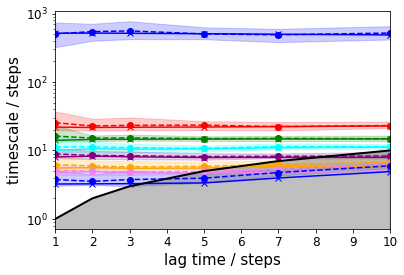

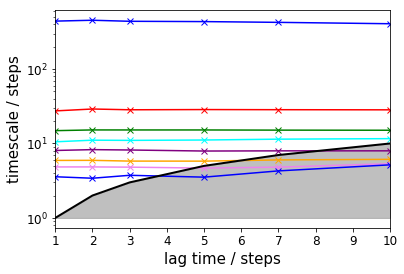

In [4]:
lags = [1, 2, 3, 5, 7, 10]

# MSM approach
its = pyemma.msm.its(md_dtrajs, lags=lags, nits=8, errors='bayes')
pyemma.plots.plot_implied_timescales(its, marker='x')

# TRAM approach
tram = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_centers, us_force_constants,
    md_trajs=md_trajs, md_dtrajs=md_dtrajs,
    maxiter=15000, maxerr=1.0E-15, save_convergence_info=10,
    estimator='tram', lag=lags, init='mbar', init_maxiter=2000, init_maxerr=1.0E-12)
pyemma.plots.plot_memm_implied_timescales(tram, nits=8, annotate=False, marker='x')

The TRAM approach further allows to check implied timescales for the umbrella sampling simulations:

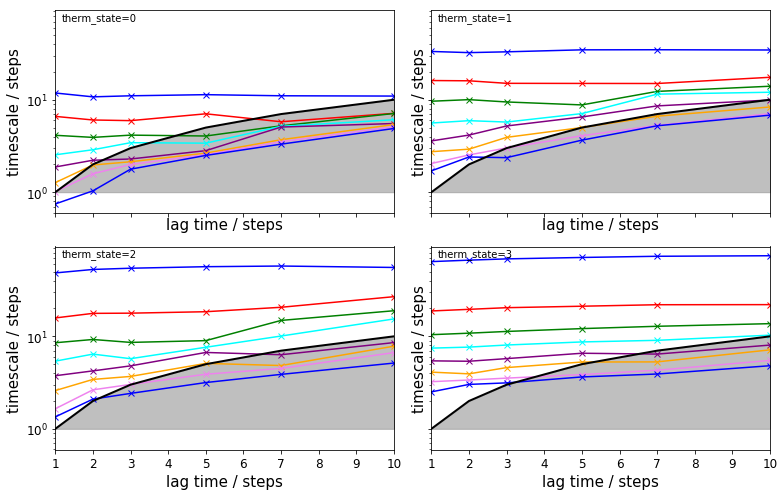

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_memm_implied_timescales(tram, nits=8, therm_state=i, ax=ax, marker='x')
fig.tight_layout()

### Performance

We compare the TRAM result with other methods, i.e., WHAM, dTRAM, and an MSM on the unbiased data with lag time $\tau=7$ steps. Please note that we do not need to rerun the TRAM estimation, we can directly access one of the TRAM objects in the above list.

HBox(children=(HBox(children=(Label(value='WHAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=100000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='WHAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=100000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='DTRAM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

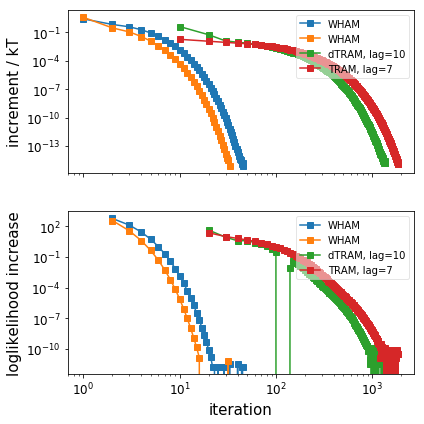

In [6]:
tram_obj = tram[4]

# Use WHAM on the biased data only
wham_1 = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_centers, us_force_constants,
    maxiter=100000, maxerr=1.0E-15, save_convergence_info=1,
    estimator='wham')

# Use WHAM on both data sets
wham_2 = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_centers, us_force_constants,
    md_trajs=md_trajs, md_dtrajs=md_dtrajs,
    maxiter=100000, maxerr=1.0E-15, save_convergence_info=1,
    estimator='wham')

# Use dTRAM on both data sets
dtram = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_centers, us_force_constants,
    md_trajs=md_trajs, md_dtrajs=md_dtrajs,
    maxiter=10000, maxerr=1.0E-15, save_convergence_info=10,
    estimator='dtram', lag=10)

# Plot the convergence behaviour (only WHAM, dTRAM, TRAM)
pyemma.plots.plot_convergence_info([wham_1, wham_2, dtram, tram_obj])

# Build an MSM of the unbiased data
msm = pyemma.msm.estimate_markov_model(dtrajs=md_dtrajs, lag=7)

Below, we compare the estimated free energy profile (thermodynamics) for the different estimators. We observe
* the MSM fails at the barrier and the right metastable state
* WHAM (us only) captures well the left metastable state and the barrier
* WHAM (us+md) fails for both metastable states
* dTRAM and TRAM are in good agreement with the reference

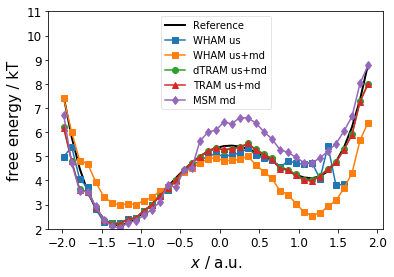

In [7]:
fig, ax = plt.subplots()
ax.plot(reference[0, :], reference[1, :], linewidth=2, color='black', label="Reference")
ax.plot(centers[wham_1.active_set, 0], wham_1.free_energies, '-s', label="WHAM us")
ax.plot(centers[wham_2.active_set, 0], wham_2.free_energies, '-s', label="WHAM us+md")
ax.plot(centers[dtram.active_set, 0], dtram.free_energies, '-o', label="dTRAM us+md")
ax.plot(centers[tram_obj.active_set, 0], tram_obj.free_energies, '-^', label="TRAM us+md")
ax.plot(centers[msm.active_set, 0], -np.log(msm.stationary_distribution), '-d', label="MSM md")
ax.set_xlabel(r"$x$ / a.u.")
ax.set_ylabel(r"free energy / kT")
ax.set_ylim([2, 11])
ax.legend(loc=9, fancybox=True, framealpha=0.5)

Now, we compare mean first passage times (MFPT, kinetics) for MSM, dTRAM, and TRAM; reference values are 370 $\pm$ 30
 steps and 2300 $\pm$ 200 steps. We observe that dTRAM and TRAM are comparably close to the reference while the MSM is off (for the slow process) by a factor of two.

  MSM MFPT[red->green] =    384 steps
  MSM MFPT[green->red] =   5280 steps
dTRAM MFPT[red->green] =    320 steps
dTRAM MFPT[green->red] =   1993 steps
 TRAM MFPT[red->green] =    243 steps
 TRAM MFPT[green->red] =   1413 steps


(1, 9)

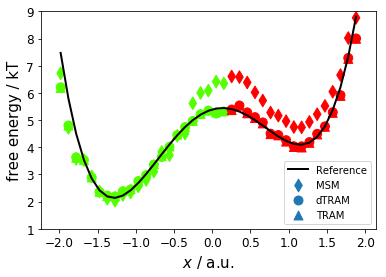

In [9]:
# Run PCCA to find metastable sets
msm.pcca(2)
dtram.msm.pcca(2)
tram_obj.msm.pcca(2)

# Print MFPTs
print("  MSM MFPT[red->green] = %6.0f steps" % msm.mfpt(msm.metastable_sets[0], msm.metastable_sets[1]))
print("  MSM MFPT[green->red] = %6.0f steps" % msm.mfpt(msm.metastable_sets[1], msm.metastable_sets[0]))
print("dTRAM MFPT[red->green] = %6.0f steps" % dtram.msm.mfpt(
        dtram.msm.metastable_sets[0], dtram.msm.metastable_sets[1]))
print("dTRAM MFPT[green->red] = %6.0f steps" % dtram.msm.mfpt(
        dtram.msm.metastable_sets[1], dtram.msm.metastable_sets[0]))
print(" TRAM MFPT[red->green] = %6.0f steps" % tram_obj.msm.mfpt(
        tram_obj.msm.metastable_sets[0], tram_obj.msm.metastable_sets[1]))
print(" TRAM MFPT[green->red] = %6.0f steps" % tram_obj.msm.mfpt(
        tram_obj.msm.metastable_sets[1], tram_obj.msm.metastable_sets[0]))

# Plot the free energy profile with color-coded metastable assignment
fig, ax = plt.subplots()
ax.plot(reference[0, :], reference[1, :], linewidth=2, color='black', label="Reference")
ax.scatter(
    centers[msm.active_set, 0], -np.log(msm.stationary_distribution),
    c=msm.metastable_assignments, cmap=mpl.cm.prism, s=80, label='MSM', marker='d')
ax.scatter(
    centers[dtram.msm.active_set, 0], dtram.f_full_state[dtram.msm.active_set],
    c=dtram.msm.metastable_assignments, cmap=mpl.cm.prism, s=80, label='dTRAM')
ax.scatter(
    centers[tram_obj.msm.active_set, 0], tram_obj.f_full_state[tram_obj.msm.active_set],
    c=tram_obj.msm.metastable_assignments, cmap=mpl.cm.prism, s=80, marker='^', label='TRAM')
ax.set_xlabel(r"$x$ / a.u.")
ax.set_ylabel(r"free energy / kT")
ax.legend(loc=4)
ax.set_ylim([1, 9])

### Conclusion

This notebook illustrates how we can use PyEMMA's thermo package to analyze umbrella sampling and unbiased simulations. We have learned how to

* invoke the ``pyemma.thermo.estimate_umbrella_sampling()`` API function,
* specify a certain estimator (WHAM, dTRAM, or TRAM)
* visualize implied timescales for arbitraty thermodynamic states
* visualize the convergence behaviour of an MEMM estimation
* access thermodynamic and kinetic information

We have also seen that transition-based reweighting of mixed biased and unbiased data outperforms traditional approaches.